### What you will need
- A single RGB landscape photo. We reuse `data/sample_landscape.jpeg`; drop in your own file if you prefer.
- CPU-only runtime is fine. Everything below falls back to PyTorch eager mode or ONNX Runtime on CPU.
- Internet access is required once so that `huggingface_hub` can cache the pretrained weights locally.
- Run the notebook top to bottom the first time so helper functions and downloads are available for later sections.

In [40]:
from __future__ import annotations

from pathlib import Path
import sys
from typing import Literal

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / "pyproject.toml").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms

from cvcourse.viz.images import show_image

DATA_DIR = PROJECT_ROOT / "data"
SAMPLE_LANDSCAPE = DATA_DIR / "sample_landscape.jpeg"
DEVICE = torch.device("cpu")
plt.style.use("ggplot")

SAMPLE_LANDSCAPE.exists() or (_ for _ in ()).throw(FileNotFoundError("Add an RGB photo at data/sample_landscape.jpeg before running the demos."))

True

### Helper utilities
We will keep I/O simple: load a PIL image once, create tensors on demand, and reuse the visualization helpers that ship with `cvcourse`. All images are resized/cropped to multiples of 4 so both CycleGAN (256×256) and ESRGAN (×4 upscaling) receive the shapes they expect.

In [41]:
def load_base_image(path: Path = SAMPLE_LANDSCAPE) -> Image.Image:
    """Load the raw RGB photo once."""
    image = Image.open(path).convert("RGB")
    return crop_to_multiple(image, divisor=4)

def crop_to_multiple(image: Image.Image, divisor: int = 4) -> Image.Image:
    """Center-crop so height/width become divisible by the divisor."""
    width, height = image.size
    new_width = width - (width % divisor)
    new_height = height - (height % divisor)
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    return image.crop((left, top, left + new_width, top + new_height))

def pil_to_cyclegan_tensor(image: Image.Image, size: int = 256) -> torch.Tensor:
    """Resize + normalize to [-1, 1] with shape (1, C, H, W)."""
    pipeline = transforms.Compose(
        [
            transforms.Resize((size, size), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )
    tensor = pipeline(image).unsqueeze(0)
    return tensor

def tensor_to_image(tensor: torch.Tensor) -> Image.Image:
    """Map a [-1, 1] tensor back to a PIL image."""
    tensor = tensor.detach().cpu().clamp(-1, 1)
    tensor = (tensor + 1) / 2
    return transforms.ToPILImage()(tensor.squeeze(0))

def show_side_by_side(images: list[Image.Image], titles: list[str], figsize=(12, 5)) -> None:
    """Simple matplotlib helper for PIL images."""
    _, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:
        axes = [axes]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

### CycleGAN: Season transfer (summer ↔ winter)
We use a pretrained CycleGAN generator from Hugging Face that can transform images between summer and winter styles. The model architecture is defined in `cvcourse.models.gans`.

In [42]:
from cvcourse.models.gans import load_cyclegan_generator

@torch.no_grad()
def transfer_season(image: Image.Image, direction: Literal["summer2winter", "winter2summer"]) -> Image.Image:
    generator = load_cyclegan_generator(direction).to(DEVICE)
    tensor = pil_to_cyclegan_tensor(image).to(DEVICE)
    translated = generator(tensor)
    return tensor_to_image(translated)

### Run the season-transfer demo
Steps:
1. Load/crop the base image (multiple of 4 px so it also works for super-resolution later).
2. Translate it twice: summer → winter and winter → summer.
3. Compare with the original tensor view to confirm that colors shift while structure stays intact.

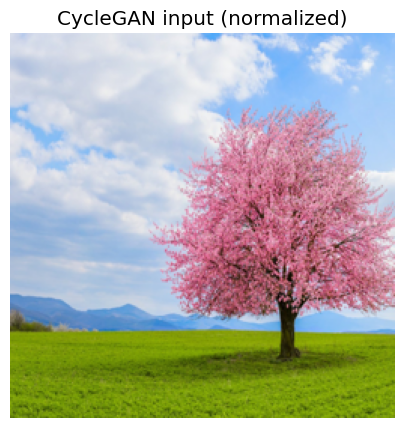

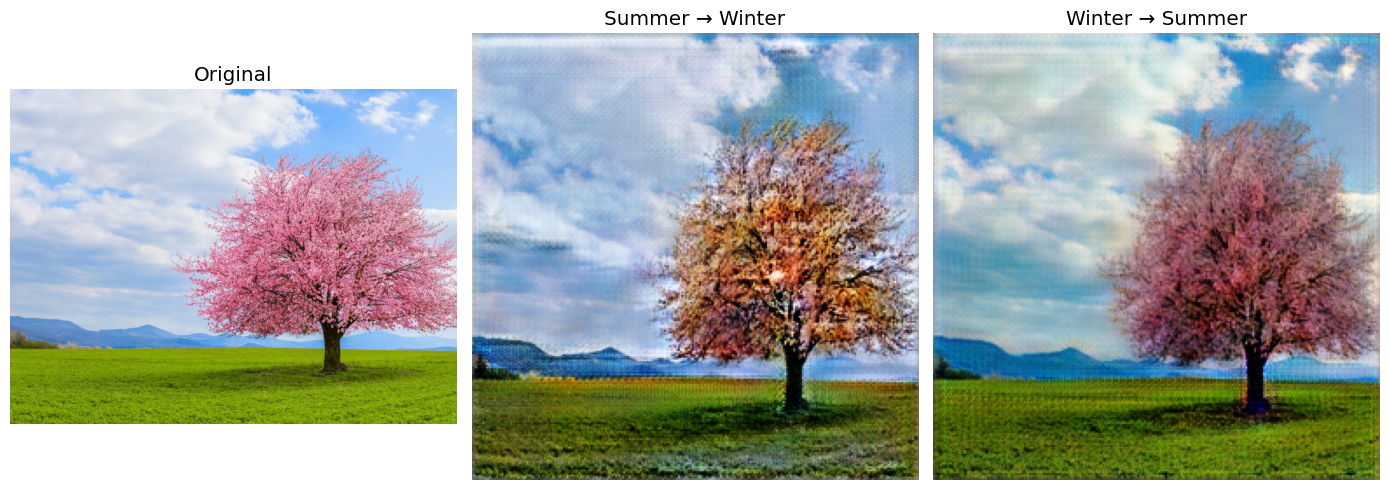

In [43]:
base_image = load_base_image()
cyclegan_tensor = pil_to_cyclegan_tensor(base_image)
show_image(((cyclegan_tensor.squeeze(0) * 0.5) + 0.5).clamp(0, 1), title="CycleGAN input (normalized)")

winterized = transfer_season(base_image, "summer2winter")
summerized = transfer_season(base_image, "winter2summer")

show_side_by_side(
    [base_image, winterized, summerized],
    ["Original", "Summer → Winter", "Winter → Summer"],
    figsize=(14, 5),
)

### ESRGAN: 4× super-resolution with ONNX Runtime
We use a pretrained ESRGAN model for super-resolution. The model is loaded via ONNX Runtime for efficient CPU inference. Utilities are in `cvcourse.models.gans`.

In [44]:
from cvcourse.models.gans import ESRGAN_SCALE, get_esrgan_session, run_esrgan

### Run the super-resolution demo
Workflow:
1. Downsample the base image by 4× to create a blurry input.
2. Upsample it back to the original resolution using two methods: bicubic interpolation and ESRGAN.
3. Compare crops to see how GAN-based hallucination sharpens edges and textures.

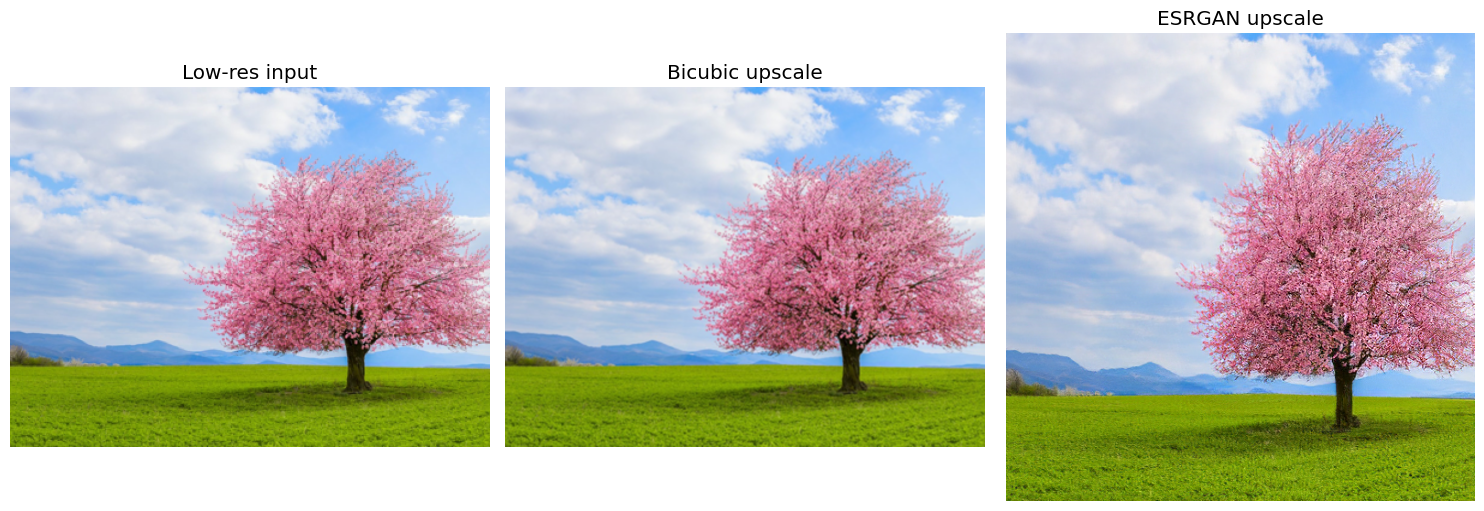

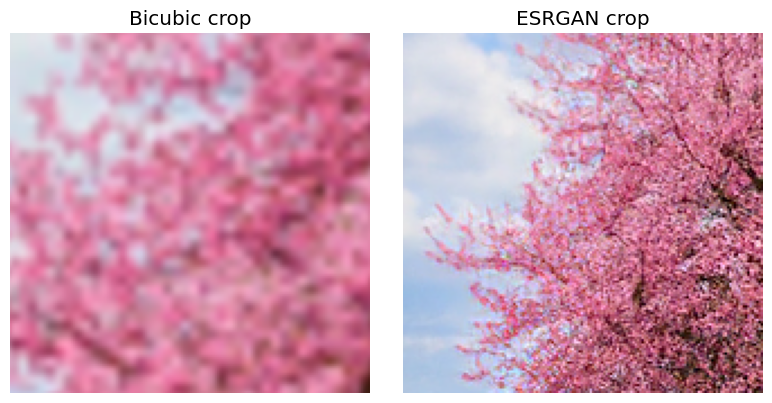

In [45]:
sr_session = get_esrgan_session()
base_image = load_base_image()

lr_width = base_image.width // ESRGAN_SCALE
lr_height = base_image.height // ESRGAN_SCALE
low_res = base_image.resize((lr_width, lr_height), Image.BICUBIC)
bicubic = low_res.resize(base_image.size, Image.BICUBIC)
gan_sr = run_esrgan(sr_session, low_res)

show_side_by_side([low_res, bicubic, gan_sr], ["Low-res input", "Bicubic upscale", "ESRGAN upscale"], figsize=(15, 5))

def center_crop(image: Image.Image, crop_size: int = 160) -> Image.Image:
    w, h = image.size
    left = (w - crop_size) // 2
    top = (h - crop_size) // 2
    return image.crop((left, top, left + crop_size, top + crop_size))

crop_size = 160
show_side_by_side(
    [center_crop(img, crop_size) for img in [bicubic, gan_sr]],
    ["Bicubic crop", "ESRGAN crop"],
    figsize=(8, 4),
)

## Where to go next
- Swap in your own photo by overwriting `data/sample_landscape.jpeg`.
- Chain both models: first shift the season, then feed the wintry scene into ESRGAN to see if the textures stay crisp.
- Move the heavy downloads to a shared cache in `data/weights/` when teaching multiple sessions so students can run the demos offline.